In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from scipy.signal import convolve2d

# Homework 1

## (A) Choosing an example image


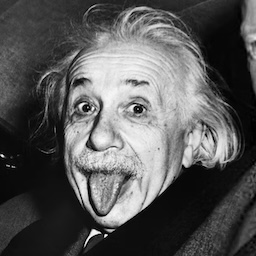

In [2]:
image = Image.open("resources/einstein.jpeg")

# Convert to grayscale
grey_avg_array = (np.sum(image, axis = -1, keepdims = False) / 3)
grey_avg_array = grey_avg_array.astype(np.uint8)
image = Image.fromarray(grey_avg_array, "L")

image

## (B) Simple center-surround receptive field

Filter the photo by the center-surround receptive fields of the retinal ganglion cells. You can start with the practice of the toy models of the center-surround receptive fields that we used in the tutorial. These toy models have receptive field’s shape described by $K(x, y)$ as a function of horizontal and vertical displacement $x$ and $y$ from the center of the receptive field. 

$$
K(x, y) = \begin{cases}
      1 & \text{ when }\ |x| < L/2 \text{, } |y| < L/2\\
      -v & \text{ when }\ |x| \geq L/2 \text{, } |y| \geq L/2
    \end{cases}
$$

Give a couple of examples using different parameters $L$ and $v$. Plot out the responses of the ganglion cells as an image to show the outcomes.

In [3]:
def square_filter(v, l):
    filter = np.ones(shape = (l, l)) * v

    # Estimate the center of the receptive field
    center = int(l / 2)

    # Estimate the width of the excitatory receptive field area
    width = int(l / 4)
    if width == 0: width = 1

    for i in range(filter.shape[0]):
        for j in range(filter.shape[1]):
            if np.abs(i - center) < width and np.abs(j - center) < width:
                filter[i, j] = 1

    return filter

In [4]:
def apply_filter(image, filter):
    return convolve2d(image, filter)

In [5]:
def plot_filter_and_image(filter, image):
    plt.subplot(1, 2, 1)
    plt.imshow(filter, cmap = "gray")
    plt.colorbar(fraction = 0.046, pad = 0.04)

    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap = "gray")
    plt.colorbar(fraction = 0.046, pad = 0.04)

    plt.tight_layout()
    plt.show()

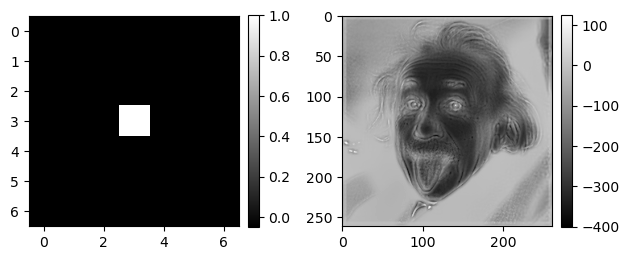

In [6]:
filter = square_filter(v = -0.05, l = 7)
plot_filter_and_image(filter, apply_filter(image, filter))

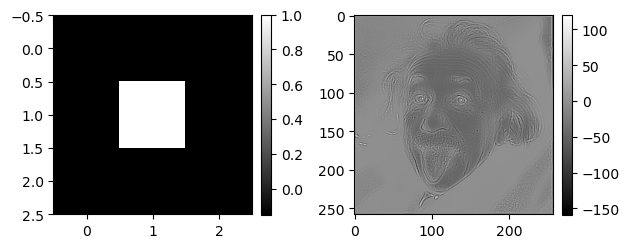

In [7]:
filter = square_filter(v = -0.15, l = 3)
plot_filter_and_image(filter, apply_filter(image, filter))

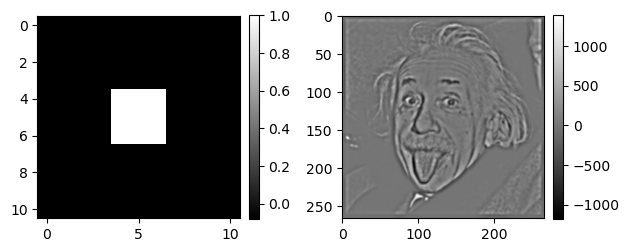

In [8]:
filter = square_filter(v = -9 / (11 * 11 - 9), l = 11)
plot_filter_and_image(filter, apply_filter(image, filter))

## (C) Difference-of-Gaussians filter

Repeat (B) using a difference-of-gaussian $K(x, y)$ as

$$
K(x, y) = \frac{w_c}{\sigma_c^2} exp(-\frac{x^2+y^2}{2\sigma_c^2}) - \frac{w_s}{\sigma_s^2} exp(-\frac{x^2+y^2}{2\sigma_s^2})
$$

Play with parameters $w_c$, $w_s$, $\sigma_c$ and $\sigma_s$ and understand how $K(x, y)$ changes with each these parameters, and thus the meaning of these parameters. Filter the original image using this $K(x, y)$ and see the outcome as the retinal ganglion cells population responses. For a retinal ganglion cell, you may try $w_c = 1.1w_s$ and $\sigma_s = 5\sigma_c$.


In [13]:
def gaussian(w_c, w_s, sigma_c, sigma_s, x, y):
    return w_c / pow(sigma_c, 2) * np.exp(-(pow(x, 2) + pow(y, 2)) / 2 * pow(sigma_c, 2)) - \
        w_s / pow(sigma_s, 2) * np.exp(-(pow(x, 2) + pow(y, 2)) / 2 * pow(sigma_s, 2))

In [14]:
def gaussian_filter(w_c, w_s, sigma_c, sigma_s, l = 101):
    filter = np.zeros(shape = (l, l))

    center = int(l / 2)

    for i in range(filter.shape[0]):
        for j in range(filter.shape[1]):
            filter[i, j] = gaussian(w_c, w_s, sigma_c, sigma_s, i - center, j - center)

    return filter

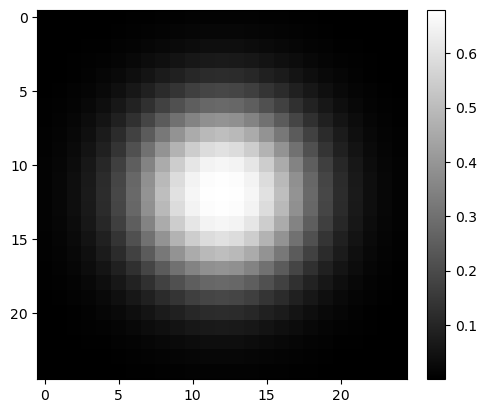

In [80]:
filter = gaussian_filter(0.055, 0.05, 0.25, 0.5, l = 25)

plt.imshow(filter, cmap = "gray")
plt.colorbar(fraction = 0.046, pad = 0.04)
plt.show()

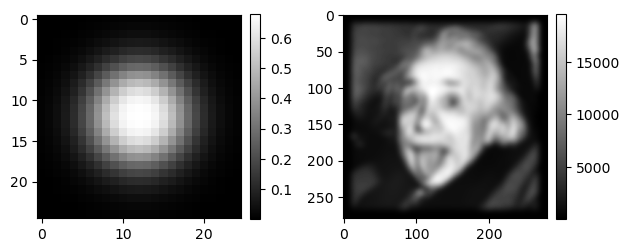

In [81]:
plot_filter_and_image(filter, apply_filter(image, filter))